# **TF**

> Curso: Complex Networks

> Tema: Research Nodes

> Integrantes:
* Cano Chocce, Samuel Esteban –  U202116508
* Guerrero Icochea, Nicolas Miguel – U202115535
* Puglisevich Vergara, Eduardo Elias – U20201E850
* Paredes Espinoza, Fernando Samuel - U202122837 


> Seccion: CC74

## Carga de datos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import regex as re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import Levenshtein as lev
from sentence_transformers import SentenceTransformer, util
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from cdlib import algorithms
from cdlib import evaluation
from cdlib import viz
from PIL import Image
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
df_articles = pd.read_csv('data/data.csv')
df_articles.head()

In [ ]:
i = 1
for c in df_articles.columns:
  print(f"Columna {i}: {c}")
  i+=1

In [322]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Authors            985 non-null    object
 1   Author full names  985 non-null    object
 2   Author(s) ID       985 non-null    object
 3   Title              1000 non-null   object
 4   Year               1000 non-null   int64 
 5   Source title       1000 non-null   object
 6   Cited by           1000 non-null   int64 
 7   DOI                878 non-null    object
 8   Link               1000 non-null   object
 9   Abstract           1000 non-null   object
 10  Index Keywords     521 non-null    object
 11  Search_Etiquette   1000 non-null   object
dtypes: int64(2), object(10)
memory usage: 93.9+ KB


## Preprocesamiento de datos

In [324]:
df_articles_clean = df_articles.copy()

In [325]:
df_articles_clean.isna().sum()

Authors               15
Author full names     15
Author(s) ID          15
Title                  0
Year                   0
Source title           0
Cited by               0
DOI                  122
Link                   0
Abstract               0
Index Keywords       479
Search_Etiquette       0
dtype: int64

In [389]:
#Eliminamos las observaciones con valores nulos en autores y source_title
df_articles_clean = df_articles_clean.dropna(subset=['Authors', 'Source title'])

#Eliminamos las columnas que no aportan información relevante para el análisis
df_articles_clean = df_articles_clean.drop(columns=['Author full names','Author(s) ID','Cited by','Index Keywords'])
df_articles_clean.reset_index(drop=True, inplace=True)

#A los NaN de DOI les asignamos un valor vacío
df_articles_clean['DOI'] = df_articles_clean['DOI'].fillna('No DOI available')

#Agregamos un ID a cada artículo
df_articles_clean['ID'] = df_articles_clean.index + 1

In [390]:
df_articles_clean.isna().sum()

Authors             0
Title               0
Year                0
Source title        0
DOI                 0
Link                0
Abstract            0
Search_Etiquette    0
ID                  0
dtype: int64

In [391]:
df_articles_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Authors           985 non-null    object
 1   Title             985 non-null    object
 2   Year              985 non-null    int64 
 3   Source title      985 non-null    object
 4   DOI               985 non-null    object
 5   Link              985 non-null    object
 6   Abstract          985 non-null    object
 7   Search_Etiquette  985 non-null    object
 8   ID                985 non-null    int64 
dtypes: int64(2), object(7)
memory usage: 69.4+ KB


In [392]:
df_articles_clean.to_csv('data_clean.csv', index=False)

## Visualización inicial

In [ ]:
#Cantidad de documentos por tag
fig, ax = plt.subplots(figsize=(20,8))
counts = df_articles_clean['Search_Etiquette'].value_counts().reset_index()
sns.barplot(x='Search_Etiquette', y='count', data=counts, palette='viridis',ax=ax)
plt.title('Cantidad de documentos por etiqueta')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de documentos')
for container in ax.containers:
    ax.bar_label(container, labels=[int(label) for label in container.datavalues], fontsize=15, padding=2)
plt.show()

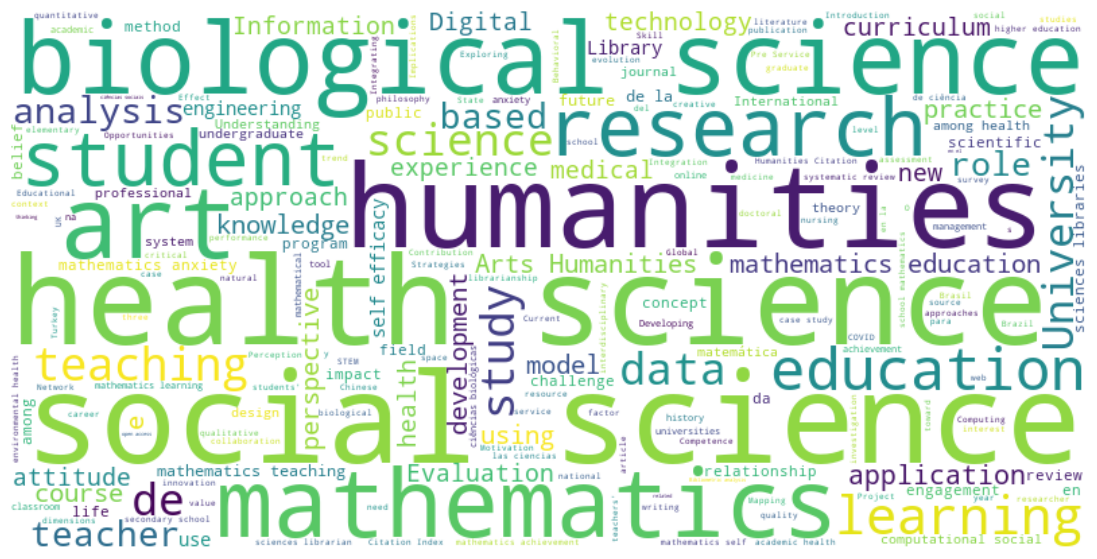

In [240]:
#Wordcloud de los títulos
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, max_font_size=110, background_color ='white').generate(' '.join(df_articles_clean['Title']))
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## Calculo de Similitud entre titulos

In [ ]:
#Extraemos valores a un diccionario
titles = {}
abstracts = {}
tags = {}
for index, row in df_articles_clean.iterrows():
    title = row['Title']
    abstract = row['Abstract']
    tag = row['Search_Etiquette']
    titles[index+1] = title
    abstracts[index+1] = abstract
    tags[index+1] = tag

In [ ]:
#Empezamos con un grafo completamente conectado
article_ids = df_articles_clean['ID'].tolist()
adjacency_list = {}
for i in article_ids:
    adjacency_list[i] = article_ids.copy()
    adjacency_list[i].remove(i)
adjacency_list

### Similitud de cosenos

In [241]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

def calculate_cosine_similarity(text1, text2):
    text1 = preprocess_text(text1)
    text2 = preprocess_text(text2)
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]

In [242]:
similarity_matrix = {}
weighted_adjacency_list_cosine = {}
for node, neighbors in adjacency_list.items():
    weighted_adjacency_list_cosine[node] = []
    for neighbor in neighbors:
        if (node, neighbor) in similarity_matrix:
            weight = similarity_matrix[(node, neighbor)]
        elif (neighbor, node) in similarity_matrix: 
            weight = similarity_matrix[(neighbor, node)]
        else:
            weight = calculate_cosine_similarity(titles[node], titles[neighbor])
            similarity_matrix[(node, neighbor)] = weight
        weighted_adjacency_list_cosine[node].append((neighbor, float(weight)))


In [382]:
mean_weight = np.mean([weight for weights in weighted_adjacency_list_cosine.values() for neighbor, weight in weights])
sd_weight = np.std([weight for weights in weighted_adjacency_list_cosine.values() for neighbor, weight in weights])
min_weight = np.min([weight for weights in weighted_adjacency_list_cosine.values() for neighbor, weight in weights])
max_weight = np.max([weight for weights in weighted_adjacency_list_cosine.values() for neighbor, weight in weights])
print(f'Mean weight: {mean_weight}')
print(f'Standard deviation weight: {sd_weight}')
print(f'Min weight: {min_weight}')
print(f'Max weight: {round(max_weight,2)}')


Mean weight: 0.06021895764879637
Standard deviation weight: 0.07603572070035725
Min weight: 0.0
Max weight: 1.0


### Similitud Basada en Distancia de Edición (levenshtein)

In [302]:
def calculate_levenshtein_similarity(text1, text2):
    max_len = max(len(text1), len(text2))
    return (max_len - lev.distance(text1, text2)) / max_len

In [303]:
similarity_matrix = {}
weighted_adjacency_list_lev = {}
for node, neighbors in adjacency_list.items():
    weighted_adjacency_list_lev[node] = []
    for neighbor in neighbors:
        if (node, neighbor) in similarity_matrix:
            weight = similarity_matrix[(node, neighbor)]
        elif (neighbor, node) in similarity_matrix: 
            weight = similarity_matrix[(neighbor, node)]
        else:
            weight = calculate_levenshtein_similarity(titles[node], titles[neighbor])
            similarity_matrix[(node, neighbor)] = weight
        weighted_adjacency_list_lev[node].append((neighbor, float(weight)))


In [380]:
mean_weight = np.mean([weight for weights in weighted_adjacency_list_lev.values() for neighbor, weight in weights])
sd_weight = np.std([weight for weights in weighted_adjacency_list_lev.values() for neighbor, weight in weights])
min_weight = np.min([weight for weights in weighted_adjacency_list_lev.values() for neighbor, weight in weights])
max_weight = np.max([weight for weights in weighted_adjacency_list_lev.values() for neighbor, weight in weights])
print(f'Mean weight: {mean_weight}')
print(f'Standard deviation weight: {sd_weight}')
print(f'Min weight: {min_weight}')
print(f'Max weight: {max_weight}')


Mean weight: 0.2307780273980525
Standard deviation weight: 0.056545304515351995
Min weight: 0.0
Max weight: 1.0


### Similitud Semántica Basada en Sentence Transformers (SBERT)

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def calculate_sbert_similarity(text1, text2):
    embeddings1 = model.encode(text1, convert_to_tensor=True)
    embeddings2 = model.encode(text2, convert_to_tensor=True)
    return util.pytorch_cos_sim(embeddings1, embeddings2).item()


In [ ]:
weighted_adjacency_list_SBERT = {}
similarity_matrix = {}
for node, neighbors in adjacency_list.items():
    weighted_adjacency_list_SBERT[node] = []
    for neighbor in neighbors:
        if (node, neighbor) in similarity_matrix:
            weight = similarity_matrix[(node, neighbor)]
        elif (neighbor, node) in similarity_matrix: 
            weight = similarity_matrix[(neighbor, node)]
        else:
            weight = calculate_sbert_similarity(titles[node], titles[neighbor])
            similarity_matrix[(node, neighbor)] = weight
        weighted_adjacency_list_SBERT[node].append((neighbor, float(weight)))

In [ ]:
mean_weight = np.mean([weight for weights in weighted_adjacency_list_SBERT.values() for neighbor, weight in weights])
sd_weight = np.std([weight for weights in weighted_adjacency_list_SBERT.values() for neighbor, weight in weights])
min_weight = np.min([weight for weights in weighted_adjacency_list_SBERT.values() for neighbor, weight in weights])
max_weight = np.max([weight for weights in weighted_adjacency_list_SBERT.values() for neighbor, weight in weights])
print(f'Mean weight: {mean_weight}')
print(f'Standard deviation weight: {sd_weight}')
print(f'Min weight: {min_weight}')
print(f'Max weight: {max_weight}')
weighted_adjacency_list_SBERT

### Visualización de los grafos obtenidos

In [ ]:
def create_weighted_graph(weighted_adjacency_list, threshold):
    G = nx.Graph()
    for node in weighted_adjacency_list.keys():
        G.add_node(node)
    for node, neighbors in weighted_adjacency_list.items():
        for neighbor, weight in neighbors:
            if weight >= threshold:
                G.add_edge(node, neighbor, weight=round(weight,3))
    return G

def create_weighted_subgraph(G, node, depth, visited=None):
    if visited is None:
        visited = set()
    subgraph = nx.Graph()
    subgraph.add_node(node)
    visited.add(node)
    if depth == 0:
        return subgraph
    neighbors = list(G.neighbors(node))
    for neighbor in neighbors:
        if neighbor not in visited:
            weight = G[node][neighbor]['weight']
            subgraph.add_node(neighbor)
            subgraph.add_edge(node, neighbor, weight=weight)
            subgraph = nx.compose(subgraph, create_weighted_subgraph(G, neighbor, depth-1, visited))  
    return subgraph

def draw_weighted_graph(G):    
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=10, font_weight="bold")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    plt.show()

In [ ]:
G_cos = create_weighted_graph(weighted_adjacency_list_cosine, 0.1)
G_lev = create_weighted_graph(weighted_adjacency_list_lev,0.2)
G_SBERT = create_weighted_graph(weighted_adjacency_list_SBERT,0.3)

s_node = 11
deep = 3
subgraph_cos = create_weighted_subgraph(G_cos, s_node, deep)
subgraph_lev = create_weighted_subgraph(G_lev, s_node, deep)
subgraph_SBERT = create_weighted_subgraph(G_SBERT, s_node, deep)

In [ ]:
draw_weighted_graph(subgraph_cos)

In [ ]:
draw_weighted_graph(subgraph_lev)    

In [ ]:
draw_weighted_graph(subgraph_SBERT)

### Selección del algoritmo de similitud

In [328]:
selected_adjacency_list = weighted_adjacency_list_cosine

## Aplicación de técnicas de Complex networks (Busqueda de comunidades)

In [378]:
def print_modularities(modularities,communities):
    max_density = 0
    best_threshold = 0
    for i in modularities.keys():
        density = modularities[i]/communities[i]
        print(f"Threshold: {i/100}")
        print(f"Communities: {communities[i]}")
        print(f"Modularity: {modularities[i]}")
        print(f"Modularity density: {density}")
        if density > max_density:
            max_density = density
            best_threshold = i
    print(f"Best threshold: {best_threshold/100} with a density of {max_density}")

def draw_communities(G,algorithm,labelsBool=True):
    pos = nx.spring_layout(G)
    viz.plot_network_clusters(G, algorithm, pos, figsize=(20, 20), plot_labels=True)
    if labelsBool:
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    else:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=None)
    plt.show()

def get_df_communities(G,communities):
    dictDataCommunity = {}
    for i,community in enumerate(communities):
        subgraph = G.subgraph(community)
        dictDataCommunity[f'Comunidad {i+1}'] = {
        'nodos': subgraph.number_of_nodes(),
        'enlaces': subgraph.number_of_edges(),
        'Densidad': nx.density(subgraph),
        'Grado medio': np.mean(list(dict(subgraph.degree).values())),
        'Longitud de camino medio':  nx.average_shortest_path_length(subgraph) if subgraph.number_of_nodes() > 1 else 0,
        'Coeficiente de clustering': nx.average_clustering(subgraph)
        
    }
    dfData = pd.DataFrame.from_dict(dictDataCommunity.values(), orient='columns')
    dfData.index = dictDataCommunity.keys()
    return dfData

def draw_modularity_communities(modularities,communities,zoom=0):
    auxDf = pd.DataFrame.from_dict(modularities, orient='index', columns=['Modularity'])
    auxDf = pd.concat([auxDf,pd.DataFrame.from_dict(communities, orient='index', columns=['Communities'])],axis=1)
    auxDf = auxDf.reset_index().rename(columns={'index':'Threshold'})
    
    if zoom > 0:
        auxDf = auxDf.iloc[:zoom]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Modularity", color="tab:blue")
    ax1.plot(auxDf["Threshold"], auxDf["Modularity"], label="Modularity", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax2 = ax1.twinx()
    ax2.set_ylabel("Number of Communities", color="tab:orange")
    ax2.plot(auxDf["Threshold"], auxDf["Communities"], label="Communities", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    fig.suptitle("Threshold vs Modularity and Number of Communities", fontsize=14)
    fig.tight_layout()
    fig.legend(loc="upper right")
    
    plt.show()

### Louvain

In [329]:
modularity_dict = {}
communities_dict = {}
for i in range(100):
    G = create_weighted_graph(selected_adjacency_list, i/100)
    communities = algorithms.louvain(G, weight='weight')
    if G.number_of_edges() == 0:
        continue
    modularity = evaluation.newman_girvan_modularity(G, communities)
    modularity_dict[i] = modularity.score
    communities_dict[i] = len(communities.communities)

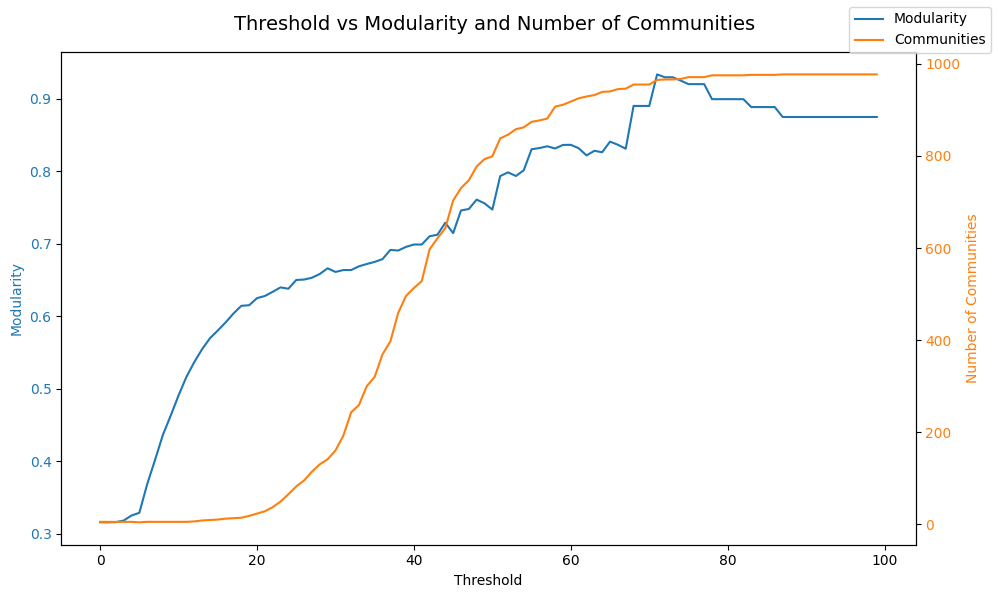

In [332]:
draw_modularity_communities(modularity_dict,communities_dict)

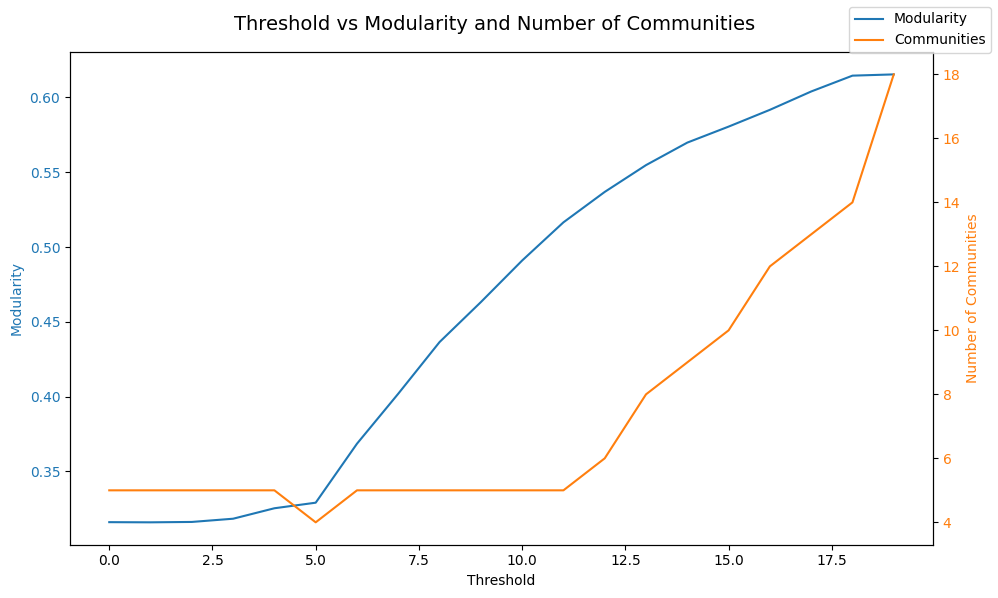

In [342]:
draw_modularity_communities(modularity_dict,communities_dict,20)

In [386]:
threshold = 0.12
G = create_weighted_graph(selected_adjacency_list, threshold)
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
lou = algorithms.louvain(G, weight='weight')
communitiesLou= lou.communities
modularity_score = evaluation.newman_girvan_modularity(G, lou)
print(f"Modularity: {modularity_score.score}")
print(f"N of communities: {len(communitiesLou)}")
print(f"N of nodes: {G.number_of_nodes()}")
print(f"N of edges: {G.number_of_edges()}")
print(communitiesLou)

Modularity: 0.5369888156808083
N of communities: 5
N of nodes: 984
N of edges: 91545
[[103, 136, 175, 182, 465, 466, 468, 545, 580, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 800, 801, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 961, 962, 963, 964, 965, 966

In [387]:
dfDataLouvain = get_df_communities(G,communitiesLou)
dfDataLouvain

nodos  enlaces  Densidad  Grado medio  Longitud de camino medio  \
Comunidad 1    202    15770  0.776809   156.138614                  1.223240   
Comunidad 2    199     9347  0.474443    93.939698                  1.534998   
Comunidad 3    198    14218  0.729016   143.616162                  1.271292   
Comunidad 4    193    14576  0.786701   151.046632                  1.213299   
Comunidad 5    192    12242  0.667648   127.520833                  1.362184   

             Coeficiente de clustering  
Comunidad 1                   0.901537  
Comunidad 2                   0.791605  
Comunidad 3                   0.894198  
Comunidad 4                   0.904377  
Comunidad 5                   0.881617

In [ ]:
draw_communities(G,lou)

### Info Map

In [347]:
modularity_dict = {}
communities_dict = {}
for i in range(100):
    G = create_weighted_graph(selected_adjacency_list, i/100)
    communities = algorithms.infomap(G)
    if G.number_of_edges() == 0:
        continue
    modularity = evaluation.newman_girvan_modularity(G, communities)
    modularity_dict[i] = modularity.score
    communities_dict[i] = len(communities.communities)

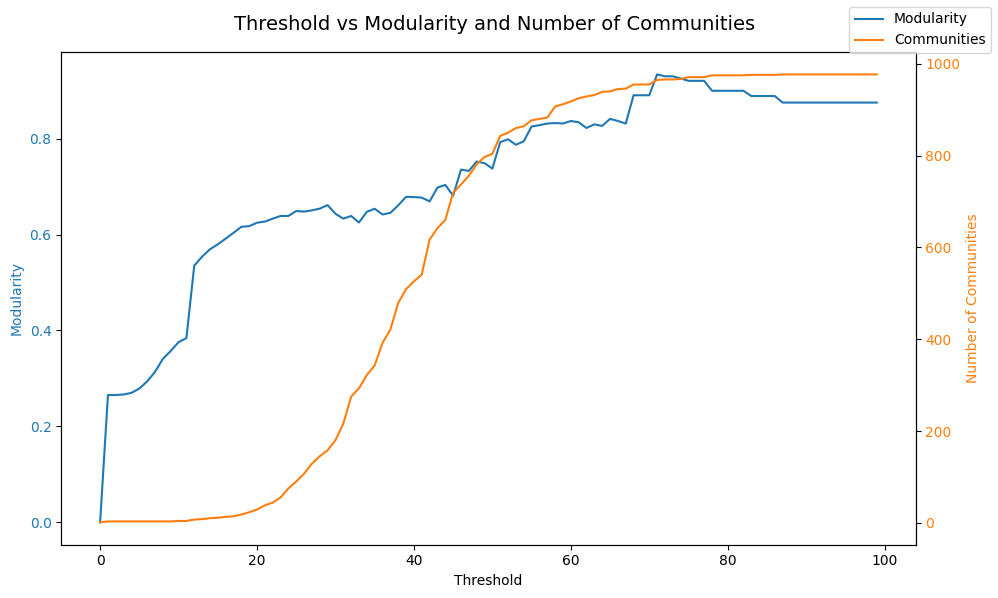

In [350]:
draw_modularity_communities(modularity_dict,communities_dict)

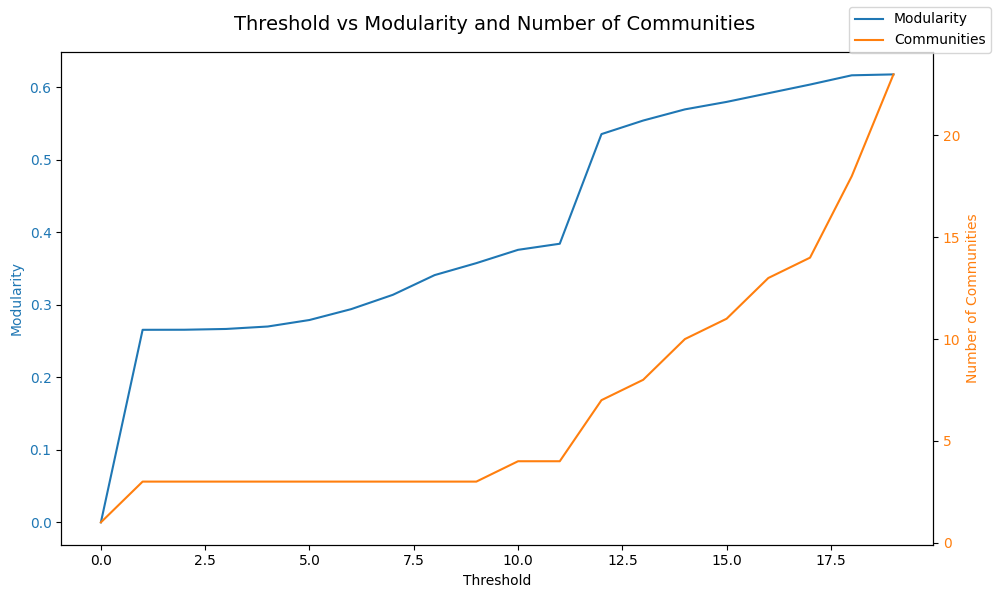

In [352]:
draw_modularity_communities(modularity_dict,communities_dict,20)

In [384]:
threshold = 0.11
G = create_weighted_graph(selected_adjacency_list, threshold)
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
im = algorithms.infomap(G)
communitiesIM= im.communities
modularity_score = evaluation.newman_girvan_modularity(G, im)
print(f"Modularity: {modularity_score.score}")
print(f"N of communities: {len(communitiesIM)}")
print(f"N of nodes: {G.number_of_nodes()}")
print(f"N of edges: {G.number_of_edges()}")
print(communitiesIM)

Modularity: 0.38396979057671365
N of communities: 4
N of nodes: 985
N of edges: 104199
[[103, 106, 136, 175, 182, 193, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 3

In [385]:
dfDataInfomap = get_df_communities(G,communitiesIM)
dfDataInfomap

nodos  enlaces  Densidad  Grado medio  Longitud de camino medio  \
Comunidad 1    593    70322  0.400631   237.173693                  1.602348   
Comunidad 2    199    10407  0.528247   104.592965                  1.477488   
Comunidad 3    192    15709  0.856730   163.635417                  1.143270   
Comunidad 4      1        0  0.000000     0.000000                  0.000000   

             Coeficiente de clustering  
Comunidad 1                   0.756010  
Comunidad 2                   0.812622  
Comunidad 3                   0.935084  
Comunidad 4                   0.000000

In [ ]:
draw_communities(G,im)

### Leiden

In [358]:
modularity_dict = {}
communities_dict = {}
for i in range(100):
    G = create_weighted_graph(selected_adjacency_list, i/100)
    communities = algorithms.leiden(G,weights='weight')
    if G.number_of_edges() == 0:
        continue
    modularity = evaluation.newman_girvan_modularity(G, communities)
    modularity_dict[i] = modularity.score
    communities_dict[i] = len(communities.communities)

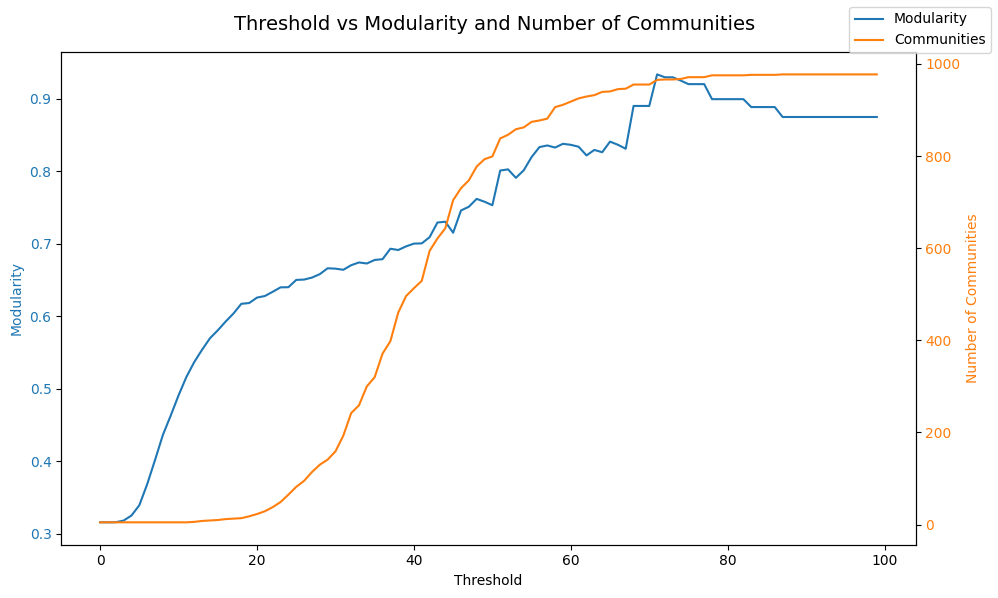

In [359]:
draw_modularity_communities(modularity_dict,communities_dict)

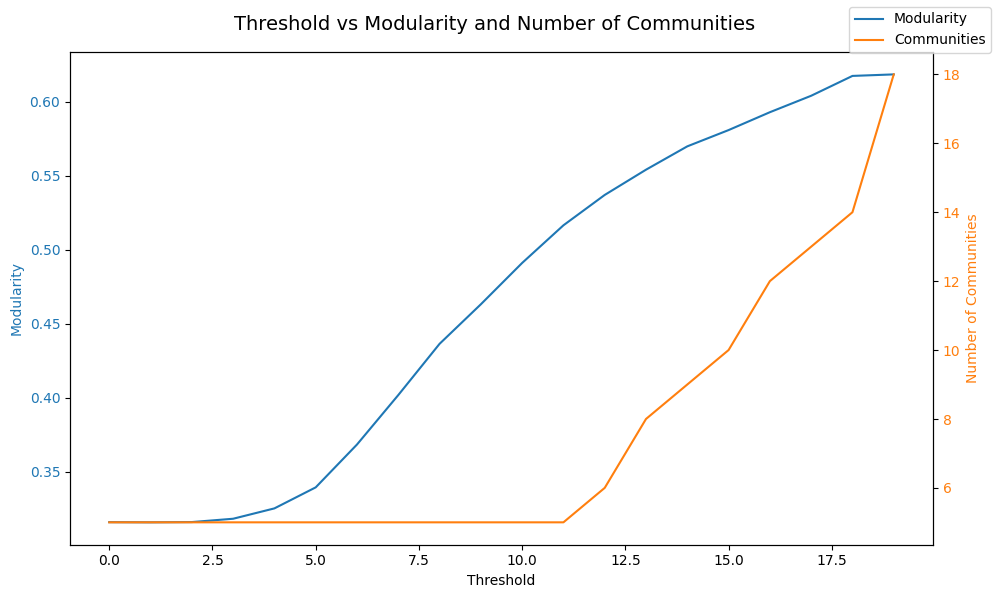

In [360]:
draw_modularity_communities(modularity_dict,communities_dict,20)

In [383]:
threshold = 0.12
G = create_weighted_graph(selected_adjacency_list, threshold)
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)
lei = algorithms.leiden(G,weights='weight')
communitiesLei= lei.communities
modularity_score = evaluation.newman_girvan_modularity(G, lei)
print(f"Modularity: {modularity_score.score}")
print(f"N of communities: {len(communitiesLei)}")
print(f"N of nodes: {G.number_of_nodes()}")
print(f"N of edges: {G.number_of_edges()}")
print(communitiesLei)

Modularity: 0.537031242465101
N of communities: 5
N of nodes: 984
N of edges: 91545
[[103, 136, 175, 182, 465, 466, 468, 545, 580, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 800, 801, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 961, 962, 963, 964, 965,

In [300]:
dfDataLeiden = get_df_communities(G,communitiesLei)
dfDataLeiden

nodos  enlaces  Densidad  Grado medio  Longitud de camino medio  \
Comunidad 1    206    15356  0.727256   149.087379                  1.273029   
Comunidad 2    199     9347  0.474443    93.939698                  1.534998   
Comunidad 3    194    14597  0.779713   150.484536                  1.220341   
Comunidad 4    194    14583  0.778965   150.340206                  1.221035   
Comunidad 5    191    12236  0.674346   128.125654                  1.346872   

             Coeficiente de clustering  
Comunidad 1                   0.891967  
Comunidad 2                   0.791605  
Comunidad 3                   0.904428  
Comunidad 4                   0.903516  
Comunidad 5                   0.882765

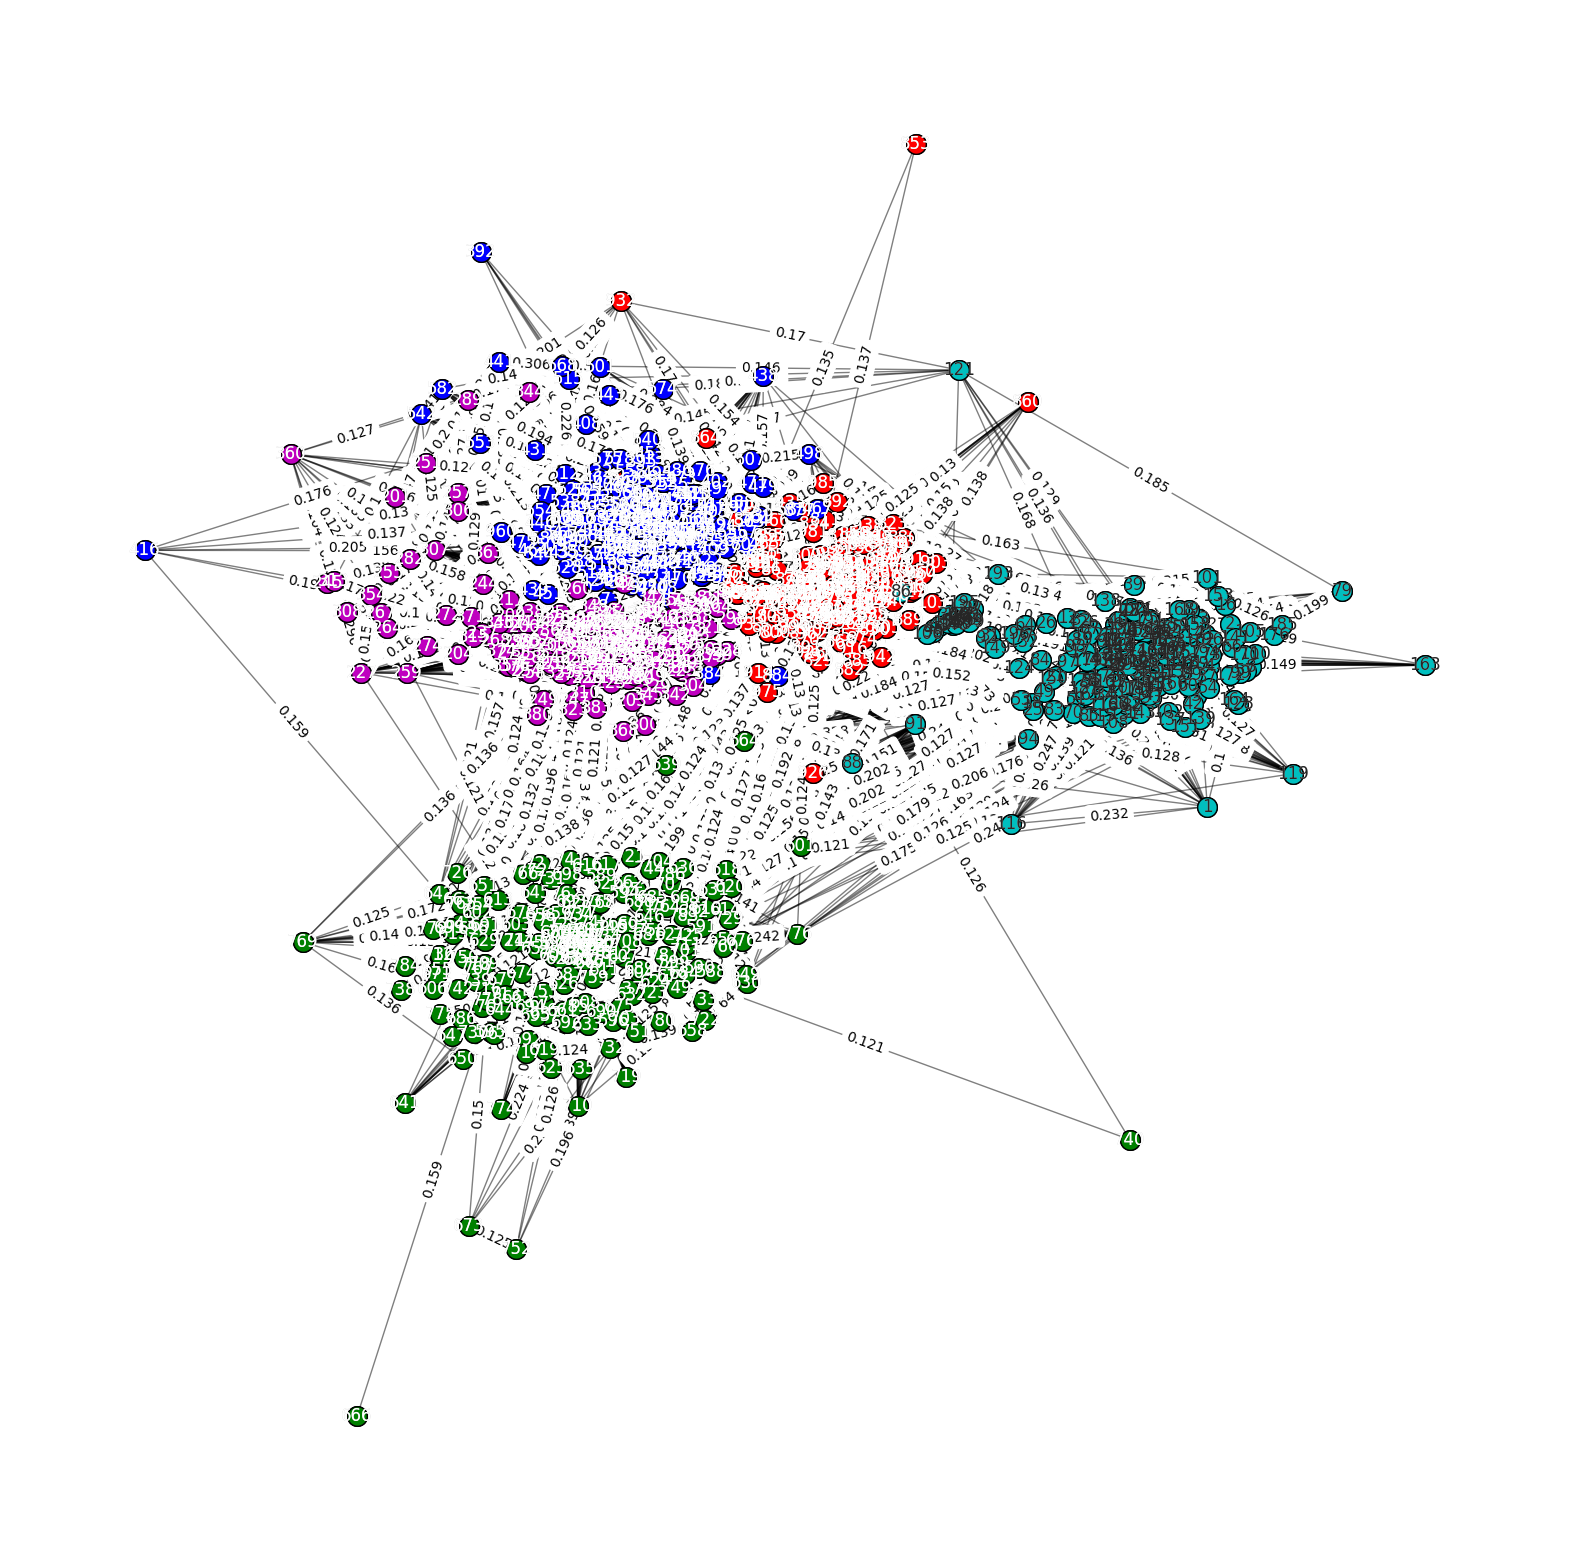

In [388]:
draw_communities(G,lei,True)

## Análisis de comunidades

Se opta por usar el algoritmo de leiden, pues presenta una mejor modularidad que los demas algoritmos seleccionados


In [ ]:
import matplotlib.colors as mcolors
def draw_net(G, pos, measures, measure_name):
    
    plt.figure(figsize=(20,20))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [367]:
communities = communitiesLei
df = get_df_communities(G,communities)
df

nodos  enlaces  Densidad  Grado medio  Longitud de camino medio  \
Comunidad 1    202    15770  0.776809   156.138614                  1.223240   
Comunidad 2    199     9347  0.474443    93.939698                  1.534998   
Comunidad 3    199    14235  0.722552   143.065327                  1.277752   
Comunidad 4    194    14583  0.778965   150.340206                  1.221035   
Comunidad 5    190    12224  0.680813   128.673684                  1.339794   

             Coeficiente de clustering  
Comunidad 1                   0.901537  
Comunidad 2                   0.791605  
Comunidad 3                   0.893406  
Comunidad 4                   0.903516  
Comunidad 5                   0.884048

### Wordclouds y tags por comunidad

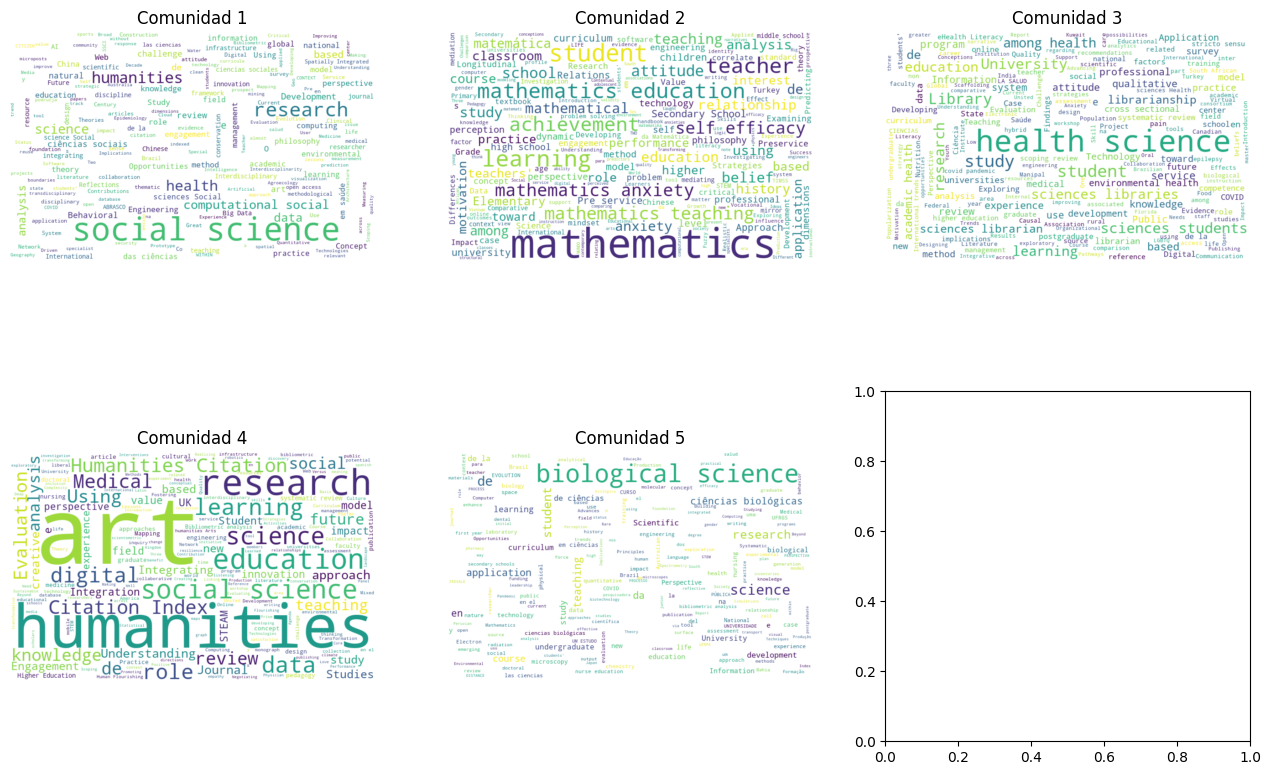

In [364]:
n = len(communities)
n1 = n//2
n2 = n - n1
fig, ax = plt.subplots(n1, n2, figsize=(16, 10))
for i in range(n1):
    for j in range(n2):
        if i*n2+j < n:
            community = communities[i*n2+j]
            text = ' '.join([titles[node] for node in community])
            wordcloud = WordCloud(width=800, height=500, background_color ='white').generate(text)
            ax[i, j].imshow(wordcloud, interpolation='bilinear')
            ax[i, j].axis('off')
            ax[i, j].set_title(f'Comunidad {i*n2+j+1}')
plt.show()

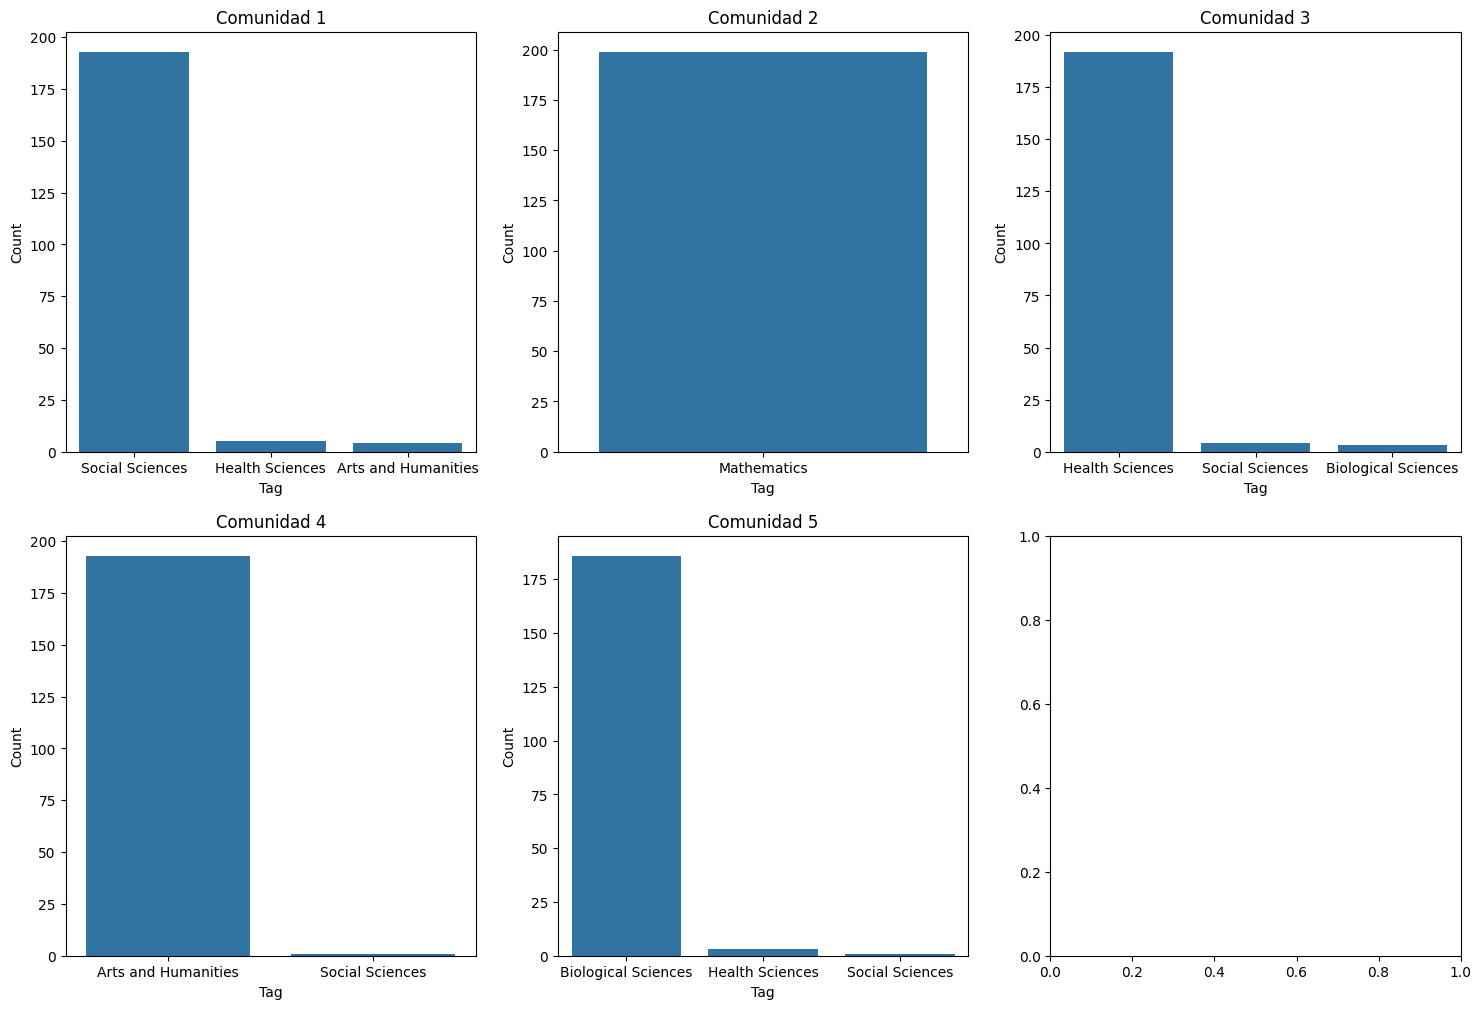

In [366]:
#Distribucion de tags por comunidad
fig, ax = plt.subplots(n1, n2, figsize=(18, 12))
for i in range(n1):
    for j in range(n2):
        if i*n2+j < n:
            community = communities[i*n2+j]
            tags_list = [tags[node] for node in community]
            tags_df = pd.DataFrame(tags_list, columns=['Tag'])
            tags_df = tags_df['Tag'].value_counts().reset_index()
            sns.barplot(x='Tag', y='count', data=tags_df, ax=ax[i, j])
            ax[i, j].set_title(f'Comunidad {i*n2+j+1}')
            ax[i, j].set_xlabel('Tag')
            ax[i, j].set_ylabel('Count')
plt.show()

### Algoritmos de centralidad

In [372]:
#Articulos más cercanos al centro de su comunidad
for i,community in enumerate(communities):
    subgraph = G.subgraph(community)
    closeness = nx.closeness_centrality(subgraph, distance="weight")
    ranks = [(k, v) for k, v in sorted(closeness.items(), key=lambda item: -item[1])]
    ranks[0:5]
    print(f"Comunidad {i+1}")
    for j in range(5):
        node = ranks[j][0]
        print(f"Rank {j+1}: {titles[node]} - Closeness: {ranks[j][1]} - ID: {node}")
    

Comunidad 1
Rank 1: Chapter 34 Remarks on the Foundations of Agent-Based Generative Social Science - Closeness: 5.4820673666984865 - ID: 919
Rank 2: Solar Geoengineering: Social Science, Legal, Ethical, and Economic Frameworks - Closeness: 5.471323189155347 - ID: 859
Rank 3: Development and prospect on national center for philosophy and social sciences documentation - Closeness: 5.4051146906176895 - ID: 793
Rank 4: Tracing the Evolution of a Discipline: Education and the Three Major Encyclopedias of the Social Sciences - Closeness: 5.398001933612632 - ID: 962
Rank 5: A Bibliometric Analysis of the Use of Artificial Intelligence Technologies for Social Sciences - Closeness: 5.358713908661921 - ID: 804
Comunidad 2
Rank 1: Mathematics and Experience - Closeness: 5.080049261083744 - ID: 594
Rank 2: Learners’ Attitude towards Mathematics, Technology on Their Mathematics Interest: The Mediating Role of Learners’ Mathematics Perception - Closeness: 4.972375690607735 - ID: 734
Rank 3: Internat

In [ ]:
for i,community in enumerate(communities):
    subgraph = G.subgraph(community)
    pr = nx.pagerank(subgraph, weight='weight')
    ranks = [(k, v) for k, v in sorted(pr.items(), key=lambda item: -item[1])]
    ranks[0:5]
    print(f"Comunidad {i+1}")
    for j in range(5):
        node = ranks[j][0]
        print(f"Rank {j+1}: {titles[node]} - Closeness: {ranks[j][1]} - ID: {node}")

Comunidad 1
Rank 1: For Science in the Social Sciences - Closeness: 0.01152615206732816 - ID: 821
Rank 2: CITIZEN SCIENCE WITH AND WITHIN THE SOCIAL SCIENCES AND THE HUMANITIES - Closeness: 0.008990650569456714 - ID: 820
Rank 3: Computational social science - Closeness: 0.008979396179498873 - ID: 795
Rank 4: Geography and social sciences in transdisciplinary science - Closeness: 0.008630127057524375 - ID: 862
Rank 5: It’s time to scale the science in the social sciences - Closeness: 0.008605940214260584 - ID: 947
Comunidad 2
Rank 1: The relationship among mathematics anxiety, beliefs about mathematics, mathematics self-efficacy, and mathematics performance in associate degree nursing students - Closeness: 0.013522921765423853 - ID: 627
Rank 2: Predicting relationships between mathematics anxiety, mathematics teaching anxiety, self-efficacy beliefs towards mathematics and mathematics teaching - Closeness: 0.012615843383800434 - ID: 605
Rank 3: The relationship between mathematics intere

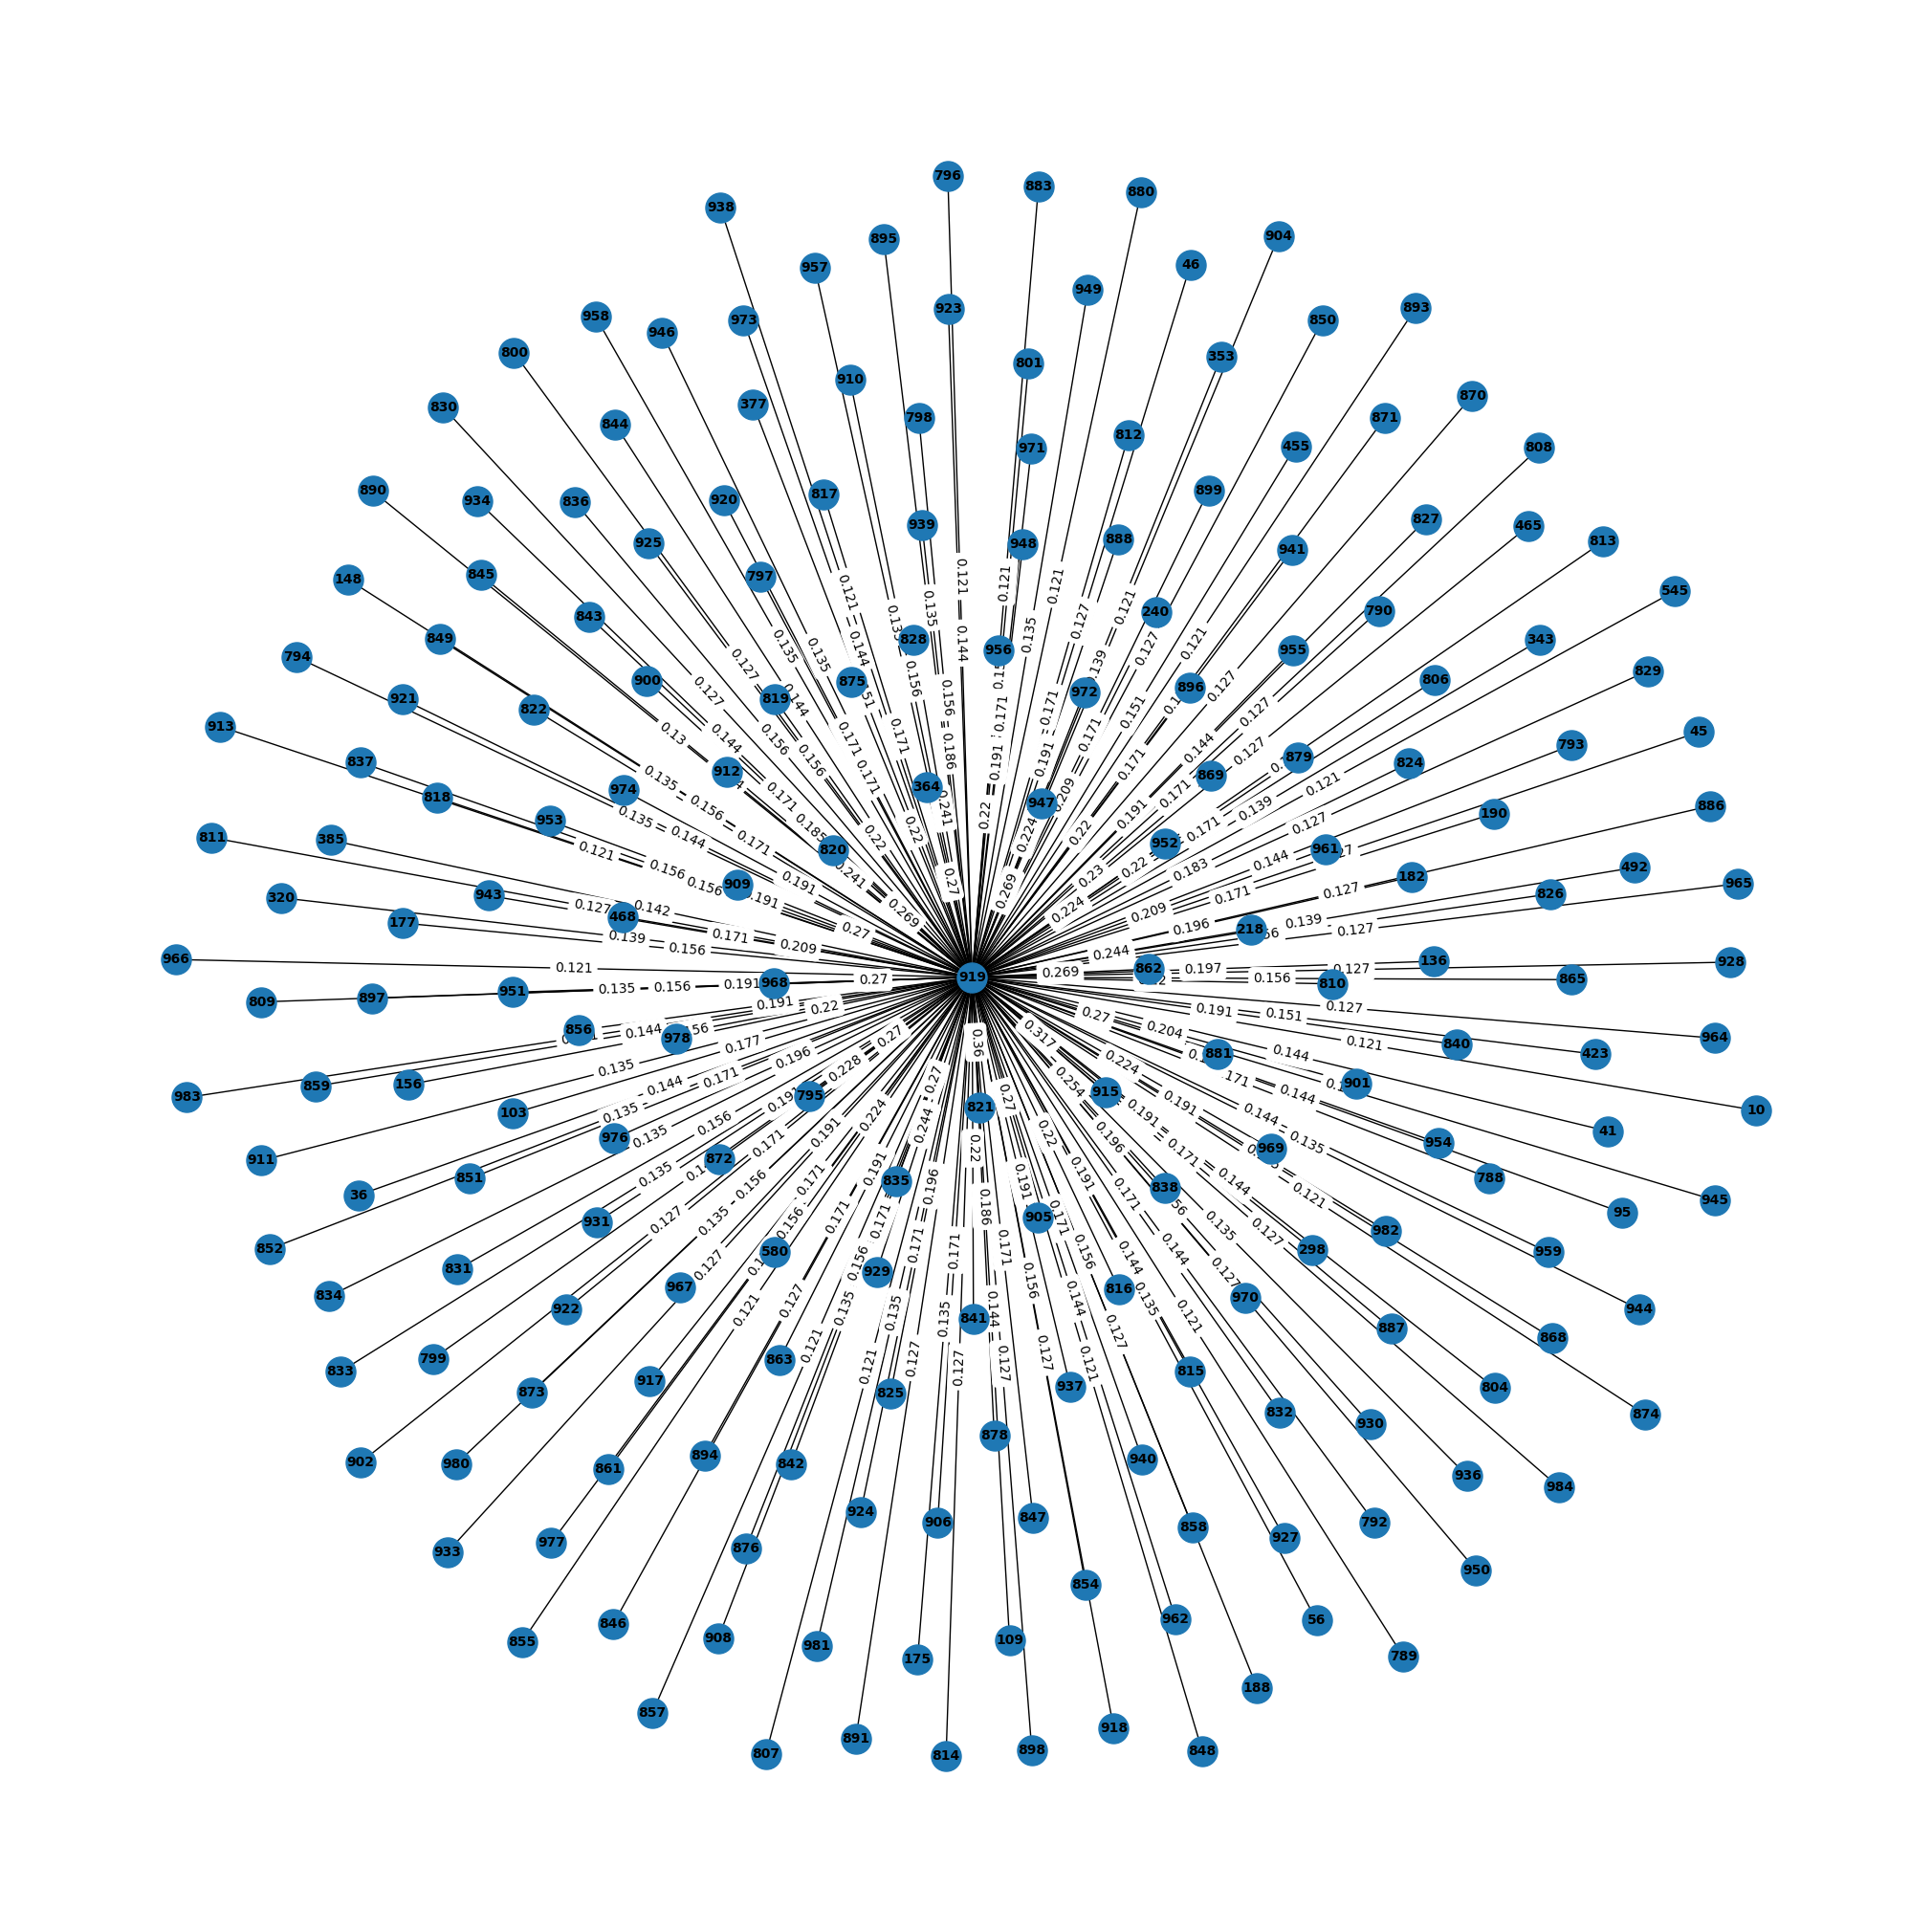

In [376]:
draw_weighted_graph(create_weighted_subgraph(G, 919, 1))